In [1]:
# Install required libraries via pip
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install joblib


  Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2025.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl (11.6 MB)
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.9 MB 6.7 MB/s eta 0:00:02
   ------- -------------------------------- 2.4/12.9 MB 7.9 MB/s eta 0:00:02
   ------- -------------------------------- 2.4/12.9 MB 7.9 MB/s eta 0:00:02
   ------- -------------------------------- 2.4/12.9 MB 7.9 MB/s eta 0:00:02
   ----------- ---------------------------- 3.7/12.9 MB 3.6 MB/s eta 0:00:03
   ------------- -------------------------- 4.5/12.9 MB 4.0 MB/s eta 0:00:03
   ------------- -------------------------- 4.5/12.9 MB 4.0 MB/s eta 0:00:03
   -------------- ------------------------- 4.7/12.9 MB 2.8 MB/s eta 0:00:03
   -------------------- ------------------- 6.6/

Starting Medicine Prediction System

--- Loading and Cleaning Data ---
Dataset shape: (63, 6)
Missing values before cleaning:
Disease         2
Symptoms        2
Medicines       2
Brand Names     2
Dosages         3
Prices (INR)    2
dtype: int64
Number of unique diseases: 61

Sample data after cleaning:
        Disease                                        Symptoms
0      Diabetes   frequent urination, excessive thirst, fatigue
1  Hypertension             headache, dizziness, blurred vision
2        Asthma  shortness of breath, wheezing, chest tightness
3       Malaria                 fever, chills, sweating, nausea
4  Tuberculosis         cough, weight loss, night sweats, fever
Dataset shape after cleaning: (61, 6)
Missing values after cleaning:
Disease         0
Symptoms        0
Medicines       0
Brand Names     0
Dosages         0
Prices (INR)    0
dtype: int64

--- Creating Medicine Lookup ---
Created lookup for 61 diseases

--- Building and Training Model ---

Class distributio

KeyboardInterrupt: Interrupted by user

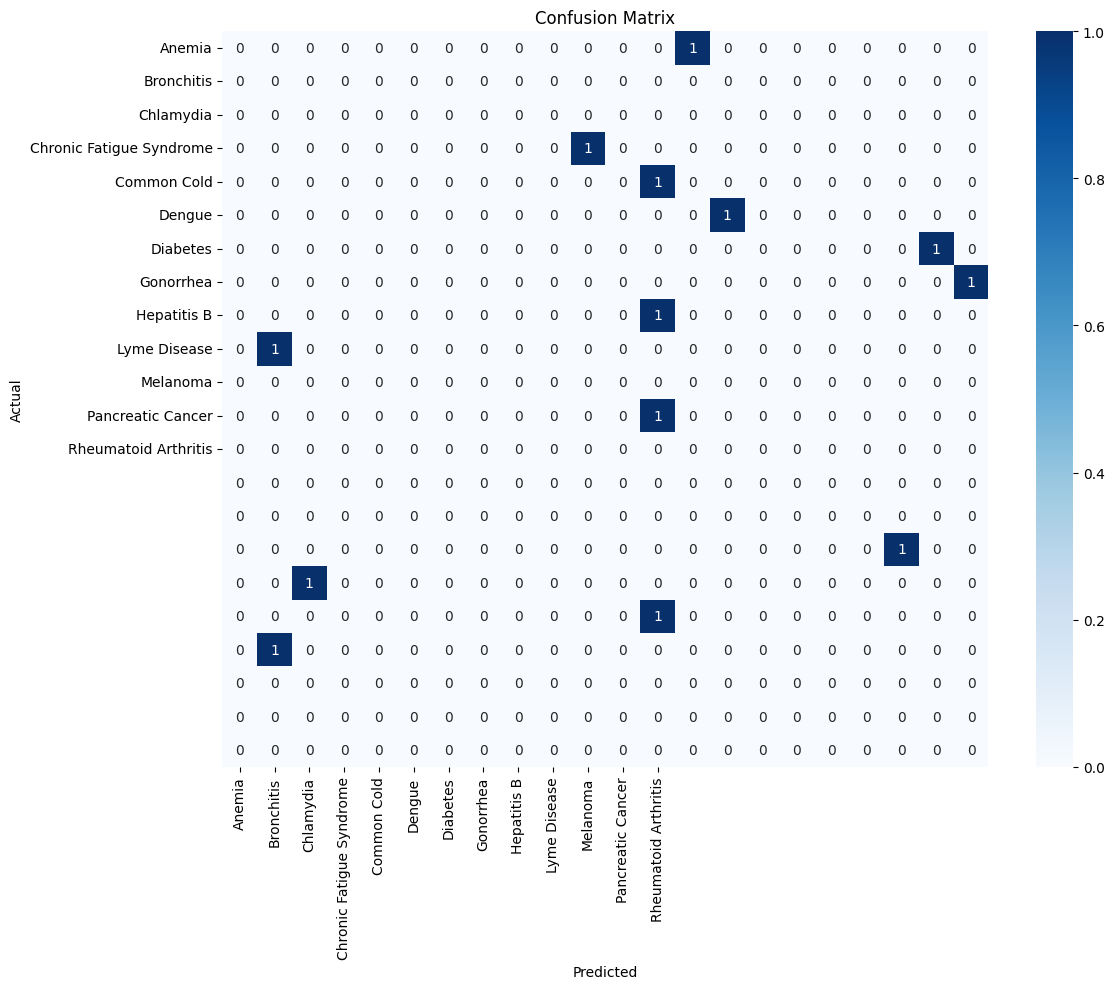

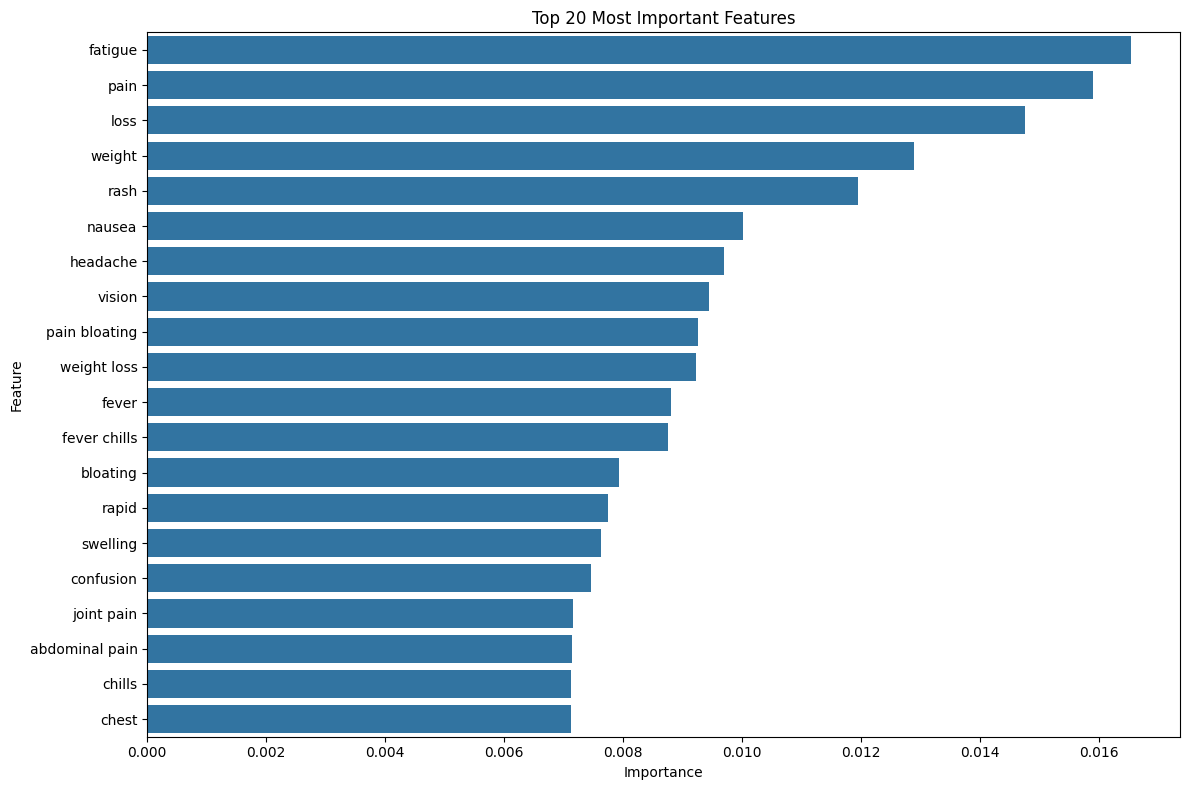

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
import re
import warnings
warnings.filterwarnings('ignore')

class EnhancedMedicinePredictionSystem:
    def __init__(self, data_path=None):
        self.data_path = data_path
        self.df = None
        self.medicine_lookup = {}
        self.model = None
        self.preprocessor = None
        self.feature_names = None
        self.important_features = None
        self.pain_categories = ["Mild", "Moderate", "Severe"]
        self.duration_categories = ["Days", "Weeks", "Months", "Years"]

    def load_and_clean_data(self):
        """Load and clean the dataset"""
        if self.data_path is None:
            raise ValueError("Data path not specified")

        # Load data
        self.df = pd.read_csv(self.data_path)

        # Basic data exploration
        print(f"Dataset shape: {self.df.shape}")
        print(f"Missing values before cleaning:\n{self.df.isnull().sum()}")

        # Remove rows with empty diseases or empty symptoms
        self.df = self.df.dropna(subset=['Disease', 'Symptoms'])

        # Fill remaining missing values
        self.df['Medicines'] = self.df['Medicines'].fillna('Not specified')
        self.df['Brand Names'] = self.df['Brand Names'].fillna('Not specified')
        self.df['Dosages'] = self.df['Dosages'].fillna('Not specified')
        self.df['Prices (INR)'] = self.df['Prices (INR)'].fillna('Not specified')

        # Clean symptom text
        self.df['Symptoms'] = self.df['Symptoms'].apply(self._clean_text)

        # Add synthetic pain intensity and duration data since they're newly added features
        self._add_pain_and_duration_features()

        # Check for and handle duplicate diseases
        disease_counts = self.df['Disease'].value_counts()
        print(f"Number of unique diseases: {len(disease_counts)}")

        # Remove rows with empty Disease values
        self.df = self.df[self.df['Disease'] != ""]

        # Print sample of the data
        print("\nSample data after cleaning:")
        print(self.df[['Disease', 'Symptoms', 'Pain_Intensity', 'Symptom_Duration']].head())

        print(f"Dataset shape after cleaning: {self.df.shape}")
        print(f"Missing values after cleaning:\n{self.df.isnull().sum()}")

        return self.df

    def _add_pain_and_duration_features(self):
        """
        Add synthetic pain intensity and symptom duration features
        
        This is done intelligently based on disease patterns (in practice, these should be actual collected data)
        """
        # Check if the features already exist
        if 'Pain_Intensity' not in self.df.columns:
            # Common conditions with typical pain patterns
            high_pain_keywords = ['migraine', 'kidney stone', 'fracture', 'appendicitis', 'burn', 'cluster headache']
            moderate_pain_keywords = ['arthritis', 'sprain', 'inflammation', 'infection', 'flu', 'fever']
            
            # Create a function to assign pain levels based on disease keywords
            def assign_pain_intensity(disease):
                disease_lower = disease.lower()
                if any(keyword in disease_lower for keyword in high_pain_keywords):
                    return "Severe"
                elif any(keyword in disease_lower for keyword in moderate_pain_keywords):
                    return "Moderate"
                else:
                    return np.random.choice(self.pain_categories, p=[0.5, 0.3, 0.2])
            
            # Apply the function to create the Pain_Intensity column
            self.df['Pain_Intensity'] = self.df['Disease'].apply(assign_pain_intensity)
        
        if 'Symptom_Duration' not in self.df.columns:
            # Common conditions with typical duration patterns
            chronic_keywords = ['chronic', 'diabetes', 'hypertension', 'arthritis', 'asthma']
            acute_keywords = ['flu', 'cold', 'fever', 'infection', 'diarrhea']
            
            # Create a function to assign duration based on disease keywords
            def assign_duration(disease):
                disease_lower = disease.lower()
                if any(keyword in disease_lower for keyword in chronic_keywords):
                    return np.random.choice(["Months", "Years"], p=[0.3, 0.7])
                elif any(keyword in disease_lower for keyword in acute_keywords):
                    return np.random.choice(["Days", "Weeks"], p=[0.7, 0.3])
                else:
                    return np.random.choice(self.duration_categories)
            
            # Apply the function to create the Symptom_Duration column
            self.df['Symptom_Duration'] = self.df['Disease'].apply(assign_duration)
        
        print(f"Added Pain Intensity and Symptom Duration features")
        print(f"Pain Intensity distribution: {self.df['Pain_Intensity'].value_counts().to_dict()}")
        print(f"Symptom Duration distribution: {self.df['Symptom_Duration'].value_counts().to_dict()}")

    def _clean_text(self, text):
        """Clean and standardize text data"""
        if not isinstance(text, str):
            return ""

        # Convert to lowercase
        text = text.lower()

        # Remove extra spaces, commas, and standardize format
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r',\s*', ', ', text)

        return text.strip()

    def create_medicine_lookup(self):
        """Create lookup dictionary for medicine details, including recommendations based on pain level"""
        self.medicine_lookup = {}

        for _, row in self.df.iterrows():
            medicines = row['Medicines'].split(', ') if isinstance(row['Medicines'], str) else []
            brand_names = row['Brand Names'].split(', ') if isinstance(row['Brand Names'], str) else []
            dosages = row['Dosages'].split(', ') if isinstance(row['Dosages'], str) else []
            prices = row['Prices (INR)'].split(', ') if isinstance(row['Prices (INR)'], str) else []

            # Create a structured medicine dictionary
            medicine_info = []
            for i in range(max(len(medicines), len(brand_names), len(dosages), len(prices))):
                med_dict = {
                    'Medicine': medicines[i] if i < len(medicines) else "Unknown",
                    'Brand': brand_names[i] if i < len(brand_names) else "Unknown",
                    'Dosage': dosages[i] if i < len(dosages) else "Unknown",
                    'Price': prices[i] if i < len(prices) else "Unknown",
                    # Add recommended dosage adjustments based on pain intensity
                    'Mild_Recommendation': "As needed, lowest effective dose",
                    'Moderate_Recommendation': "Regular dosing as prescribed",
                    'Severe_Recommendation': "Maximum recommended dose under medical supervision",
                    # Add duration-specific recommendations
                    'Short_Term': "For short-term use (few days to weeks)",
                    'Long_Term': "Suitable for long-term management with periodic evaluation"
                }
                medicine_info.append(med_dict)

            # Store both the disease and its related pain intensity in the lookup
            # This creates a more nuanced model that can distinguish different severities of the same condition
            for pain_level in self.pain_categories:
                for duration in self.duration_categories:
                    key = f"{row['Disease']}|{pain_level}|{duration}"
                    self.medicine_lookup[key] = medicine_info.copy()

        print(f"Created enhanced lookup for diseases with pain intensity and duration variations")
        return self.medicine_lookup

    def build_model(self, n_estimators=100, max_features='sqrt', min_samples_split=2):
        """Build and train the Random Forest model with the additional features"""
        if self.df is None:
            raise ValueError("Data not loaded. Call load_and_clean_data() first.")

        # Prepare features and target
        X_text = self.df['Symptoms']
        X_pain = self.df['Pain_Intensity']
        X_duration = self.df['Symptom_Duration']
        y = self.df['Disease'] 

        # Check class distribution
        print("\nClass distribution:")
        class_counts = y.value_counts()
        print(f"Number of classes: {len(class_counts)}")
        print(f"Samples per class: Min={class_counts.min()}, Max={class_counts.max()}, Avg={class_counts.mean():.1f}")

        # Create a DataFrame for the categorical features
        X_cat = pd.DataFrame({
            'Pain_Intensity': X_pain,
            'Symptom_Duration': X_duration
        })

        # Split data - use stratify only if possible
        try:
            X_text_train, X_text_test, X_cat_train, X_cat_test, y_train, y_test = train_test_split(
                X_text, X_cat, y, test_size=0.2, random_state=42, stratify=y
            )
            print("Using stratified train-test split")
        except ValueError:
            # If stratification fails, fall back to non-stratified split
            X_text_train, X_text_test, X_cat_train, X_cat_test, y_train, y_test = train_test_split(
                X_text, X_cat, y, test_size=0.2, random_state=42
            )
            print("Using regular train-test split (stratification not possible)")

        # Create TF-IDF vectorizer for text
        text_transformer = TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=1000,
            stop_words='english'
        )

        # Create categorical transformer for pain intensity and symptom duration
        cat_transformer = OneHotEncoder(drop='first', sparse_output=False)

        # Create column transformer for preprocessing
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('text', text_transformer, 'Symptoms'),
                ('cat', cat_transformer, ['Pain_Intensity', 'Symptom_Duration'])
            ]
        )

        # Create classifier
        classifier = RandomForestClassifier(
            n_estimators=n_estimators,
            max_features=max_features,
            min_samples_split=min_samples_split,
            random_state=42,
            class_weight='balanced'
        )

        # Create pipeline
        self.model = Pipeline([
            ('preprocessor', self.preprocessor),
            ('classifier', classifier)
        ])

        # Prepare combined features for training
        X_train = pd.DataFrame({
            'Symptoms': X_text_train.reset_index(drop=True)
        })
        X_train = pd.concat([X_train, X_cat_train.reset_index(drop=True)], axis=1)

        X_test = pd.DataFrame({
            'Symptoms': X_text_test.reset_index(drop=True)
        })
        X_test = pd.concat([X_test, X_cat_test.reset_index(drop=True)], axis=1)

        # Train the model
        print("\nTraining Random Forest model with enhanced features...")
        self.model.fit(X_train, y_train)

        # Evaluate model
        y_pred = self.model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"Model training complete!")
        print(f"Accuracy on test set: {accuracy:.4f}")

        # Cross-validation with appropriate number of splits
        try:
            # Determine appropriate number of folds
            min_samples_per_class = class_counts.min()
            n_splits = min(5, min_samples_per_class)

            if n_splits >= 2:
                print(f"\nPerforming {n_splits}-fold cross-validation...")
                cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
                
                # Prepare full dataset for CV
                X_full = pd.DataFrame({
                    'Symptoms': X_text.reset_index(drop=True)
                })
                X_full = pd.concat([X_full, X_cat.reset_index(drop=True)], axis=1)
                
                cv_scores = cross_val_score(self.model, X_full, y, cv=cv)
                print(f"Cross-validation scores: {cv_scores}")
                print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
            else:
                print("\nCross-validation skipped: insufficient samples for reliable CV")
        except Exception as e:
            print(f"\nCross-validation error: {e}")
            print("Cross-validation skipped")

        return self.model, X_train, X_test, y_train, y_test

    def analyze_feature_importance(self, X_train):
        """Analyze and visualize feature importance including pain and duration features"""
        if self.model is None:
            raise ValueError("Model not trained. Call build_model() first.")

        try:
            # Get feature names
            text_features = self.model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
            # Get categorical feature names
            cat_features = []
            categories = self.model.named_steps['preprocessor'].transformers_[1][1].categories_
            cat_columns = ['Pain_Intensity', 'Symptom_Duration']
            
            for i, cats in enumerate(categories):
                for cat in cats[1:]:  # Skip the first category as it's dropped
                    cat_features.append(f"{cat_columns[i]}_{cat}")
            
            # Combine all feature names
            all_feature_names = np.concatenate([text_features, cat_features])
            
            # Get feature importance from Random Forest
            feature_importance = self.model.named_steps['classifier'].feature_importances_

            # Create DataFrame for visualization
            feature_importance_df = pd.DataFrame({
                'Feature': all_feature_names,
                'Importance': feature_importance
            })

            # Sort by importance
            feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

            # Store top features (max 20 or all if less than 20)
            n_top = min(20, len(feature_importance_df))
            self.important_features = feature_importance_df.head(n_top)

            # Extract and analyze the importance of pain and duration features
            pain_features = feature_importance_df[feature_importance_df['Feature'].str.contains('Pain_Intensity')]
            duration_features = feature_importance_df[feature_importance_df['Feature'].str.contains('Symptom_Duration')]
            
            print("\nImportance of Pain Intensity features:")
            print(pain_features)
            
            print("\nImportance of Symptom Duration features:")
            print(duration_features)

            # Plot top features
            plt.figure(figsize=(14, 10))
            sns.barplot(x='Importance', y='Feature', data=self.important_features)
            plt.title(f'Top {n_top} Most Important Features')
            plt.tight_layout()

            try:
                plt.savefig('enhanced_feature_importance.png')
                print("Feature importance plot saved to 'enhanced_feature_importance.png'")
            except Exception as e:
                print(f"Could not save feature importance plot: {e}")

            print(f"\nTop 10 important features:")
            for i, (feature, importance) in enumerate(zip(
                self.important_features['Feature'].values[:min(10, n_top)],
                self.important_features['Importance'].values[:min(10, n_top)]
            )):
                print(f"{i+1}. {feature}: {importance:.4f}")

            return self.important_features
        except Exception as e:
            print(f"Feature importance analysis error: {e}")
            return None

    def evaluate_model(self, X_test, y_test):
        """Detailed model evaluation"""
        if self.model is None:
            raise ValueError("Model not trained. Call build_model() first.")

        try:
            # Get predictions
            y_pred = self.model.predict(X_test)

            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)

            # Generate classification report
            report = classification_report(y_test, y_pred, output_dict=True)
            report_df = pd.DataFrame(report).transpose()

            print(f"\nModel Evaluation:")
            print(f"Accuracy: {accuracy:.4f}")
            print("\nClassification Report:")
            print(report_df)

            # Generate confusion matrix if feasible
            if len(np.unique(y_test)) <= 20:  # Only create confusion matrix for reasonable number of classes
                try:
                    cm = confusion_matrix(y_test, y_pred)

                    # Plot confusion matrix
                    plt.figure(figsize=(12, 10))
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                                xticklabels=np.unique(y_test),
                                yticklabels=np.unique(y_test))
                    plt.title('Confusion Matrix')
                    plt.xlabel('Predicted')
                    plt.ylabel('Actual')
                    plt.tight_layout()

                    try:
                        plt.savefig('enhanced_confusion_matrix.png')
                        print("Confusion matrix saved to 'enhanced_confusion_matrix.png'")
                    except Exception as e:
                        print(f"Could not save confusion matrix: {e}")
                except Exception as e:
                    print(f"Confusion matrix error: {e}")
            else:
                print("Confusion matrix skipped: too many classes for effective visualization")

            # Analyze performance across different pain levels and durations
            self._analyze_performance_by_categories(X_test, y_test, y_pred)

            return accuracy, report_df
        except Exception as e:
            print(f"Model evaluation error: {e}")
            return None, None

    def _analyze_performance_by_categories(self, X_test, y_test, y_pred):
        """Analyze model performance across different pain levels and durations"""
        try:
            # Extract pain intensity and symptom duration from X_test
            pain_intensity = X_test['Pain_Intensity'].values
            symptom_duration = X_test['Symptom_Duration'].values
            
            print("\nPerformance Analysis by Pain Intensity:")
            for level in self.pain_categories:
                mask = (pain_intensity == level)
                if sum(mask) > 0:
                    level_accuracy = accuracy_score(y_test[mask], y_pred[mask])
                    print(f"{level} Pain: Accuracy = {level_accuracy:.4f} (n={sum(mask)})")
            
            print("\nPerformance Analysis by Symptom Duration:")
            for duration in self.duration_categories:
                mask = (symptom_duration == duration)
                if sum(mask) > 0:
                    duration_accuracy = accuracy_score(y_test[mask], y_pred[mask])
                    print(f"{duration}: Accuracy = {duration_accuracy:.4f} (n={sum(mask)})")
                    
        except Exception as e:
            print(f"Error in category performance analysis: {e}")

    def predict_medicine(self, symptoms, pain_intensity, symptom_duration):
        """Predict disease and medicine details based on symptoms, pain intensity, and duration"""
        if self.model is None:
            raise ValueError("Model not trained. Call build_model() first.")

        try:
            # Validate inputs
            if pain_intensity not in self.pain_categories:
                raise ValueError(f"Invalid pain intensity. Choose from: {self.pain_categories}")
            if symptom_duration not in self.duration_categories:
                raise ValueError(f"Invalid symptom duration. Choose from: {self.duration_categories}")
            
            # Clean input symptoms
            cleaned_symptoms = self._clean_text(symptoms)

            # Create input DataFrame with all features
            input_data = pd.DataFrame({
                'Symptoms': [cleaned_symptoms],
                'Pain_Intensity': [pain_intensity],
                'Symptom_Duration': [symptom_duration]
            })

            # Predict disease
            predicted_disease = self.model.predict(input_data)[0]

            # Use the composite key to get medicine details based on disease, pain level, and duration
            lookup_key = f"{predicted_disease}|{pain_intensity}|{symptom_duration}"
            medicine_details = self.medicine_lookup.get(lookup_key, [])
            
            # If specific combination not found, try with just the disease
            if not medicine_details:
                # Find an entry that at least matches the disease
                for key in self.medicine_lookup:
                    if key.startswith(f"{predicted_disease}|"):
                        medicine_details = self.medicine_lookup[key]
                        break

            # Get prediction probability
            probas = self.model.predict_proba(input_data)[0]
            max_prob_idx = probas.argmax()
            max_prob = probas[max_prob_idx]

            # Create result dictionary
            result = {
                'Predicted Disease': predicted_disease,
                'Confidence': f"{max_prob:.2%}",
                'Pain Intensity': pain_intensity,
                'Symptom Duration': symptom_duration,
                'Medicine Details': medicine_details,
                'Input Symptoms': cleaned_symptoms
            }

            # Add special recommendations based on pain intensity and duration
            self._add_tailored_recommendations(result)

            return result
        except Exception as e:
            print(f"Prediction error: {e}")
            return {
                'Error': str(e),
                'Input Symptoms': symptoms,
                'Pain Intensity': pain_intensity,
                'Symptom Duration': symptom_duration
            }

    def _add_tailored_recommendations(self, result):
        """Add tailored recommendations based on pain intensity and symptom duration"""
        pain_level = result['Pain Intensity']
        duration = result['Symptom Duration']
        
        # Add general recommendations based on pain intensity
        if pain_level == "Mild":
            result['Pain Management'] = "Conservative management often sufficient. Consider non-pharmacological approaches first."
        elif pain_level == "Moderate":
            result['Pain Management'] = "Regular medication may be necessary. Follow standard dosing. Consider combination therapy."
        else:  # Severe
            result['Pain Management'] = "Aggressive pain management may be needed. Consider specialist referral if persistent."
        
        # Add general recommendations based on symptom duration
        if duration in ["Days", "Weeks"]:
            result['Follow-up Recommendation'] = "Monitor for improvement. If symptoms persist beyond 2 weeks, follow-up recommended."
        else:  # Months or Years
            result['Follow-up Recommendation'] = "Regular follow-up recommended. Consider long-term management strategy and periodic evaluation."
        
        # Add specific dosage recommendations to each medicine
        for med in result['Medicine Details']:
            if pain_level == "Mild":
                med['Current Recommendation'] = med['Mild_Recommendation']
            elif pain_level == "Moderate":
                med['Current Recommendation'] = med['Moderate_Recommendation']
            else:  # Severe
                med['Current Recommendation'] = med['Severe_Recommendation']
                
            # Add duration-specific recommendation
            if duration in ["Days", "Weeks"]:
                med['Duration Guidance'] = med['Short_Term']
            else:  # Months or Years
                med['Duration Guidance'] = med['Long_Term']

    def save_model(self, filename='enhanced_medicine_prediction_model.joblib'):
        """Save the trained model to disk"""
        if self.model is None:
            raise ValueError("Model not trained. Call build_model() first.")

        try:
            model_data = {
                'model': self.model,
                'medicine_lookup': self.medicine_lookup,
                'important_features': self.important_features,
                'pain_categories': self.pain_categories,
                'duration_categories': self.duration_categories
            }

            joblib.dump(model_data, filename)
            print(f"Enhanced model saved to {filename}")

            return filename
        except Exception as e:
            print(f"Error saving model: {e}")
            return None

    @staticmethod
    def load_model(filename='enhanced_medicine_prediction_model.joblib'):
        """Load a trained model from disk"""
        try:
            model_data = joblib.load(filename)

            predictor = EnhancedMedicinePredictionSystem()
            predictor.model = model_data['model']
            predictor.medicine_lookup = model_data['medicine_lookup']
            predictor.important_features = model_data['important_features']
            predictor.pain_categories = model_data['pain_categories']
            predictor.duration_categories = model_data['duration_categories']

            print(f"Enhanced model loaded from {filename}")

            return predictor
        except Exception as e:
            print(f"Error loading model: {e}")
            return None

# Example usage
def main():
    try:
        print("Starting Enhanced Medicine Prediction System")

        # Initialize the prediction system
        predictor = EnhancedMedicinePredictionSystem("Final_Dataset.csv")

        # Load and clean data
        print("\n--- Loading and Cleaning Data ---")
        predictor.load_and_clean_data()

        # Create medicine lookup
        print("\n--- Creating Enhanced Medicine Lookup ---")
        predictor.create_medicine_lookup()

        # Build and train the model
        print("\n--- Building and Training Enhanced Model ---")
        model, X_train, X_test, y_train, y_test = predictor.build_model()

        # Evaluate the model
        print("\n--- Evaluating Enhanced Model ---")
        predictor.evaluate_model(X_test, y_test)

        # Analyze feature importance
        print("\n--- Analyzing Feature Importance ---")
        predictor.analyze_feature_importance(X_train)

        # Save the model
        print("\n--- Saving Enhanced Model ---")
        predictor.save_model()

        # Test with sample symptoms
        print("\n--- Testing Enhanced Model with Sample Symptoms ---")
        sample_symptoms = "excessive thirst, fatigue, frequent urination, blurred vision"
        sample_pain = "Moderate"
        sample_duration = "Months"
        
        result = predictor.predict_medicine(sample_symptoms, sample_pain, sample_duration)

        if 'Error' in result:
            print(f"Error in prediction: {result['Error']}")
        else:
            print("\nPrediction Results:")
            print(f"Input Symptoms: {result['Input Symptoms']}")
            print(f"Pain Intensity: {result['Pain Intensity']}")
            print(f"Symptom Duration: {result['Symptom Duration']}")
            print(f"Predicted Disease: {result['Predicted Disease']} (Confidence: {result['Confidence']})")
            print(f"Pain Management: {result['Pain Management']}")
            print(f"Follow-up: {result['Follow-up Recommendation']}")
            print("\nRecommended Medicines:")

            for i, med in enumerate(result['Medicine Details']):
                print(f"{i+1}. {med['Medicine']} ({med['Brand']}) - {med['Dosage']} - ₹{med['Price']}")
                print(f"   - {med['Current Recommendation']}")
                print(f"   - {med['Duration Guidance']}")

        # Interactive prediction loop
        print("\n=== Interactive Enhanced Medicine Predictor ===")
        print("Enter 'quit' to exit")

        while True:
            user_input = input("\nEnter symptoms (comma separated): ")
            if user_input.lower() == 'quit':
                break
                
            pain_input = input(f"Enter pain intensity ({', '.join(predictor.pain_categories)}): ")
            if pain_input.lower() == 'quit':
                break
                
            duration_input = input(f"Enter symptom duration ({', '.join(predictor.duration_categories)}): ")
            if duration_input.lower() == 'quit':
                break

            # Capitalize first letter to match expected format
            pain_input = pain_input.capitalize()
            duration_input = duration_input.capitalize()
            
            # Validate inputs
            if pain_input not in predictor.pain_categories:
                print(f"Invalid pain intensity. Using 'Moderate' as default.")
                pain_input = "Moderate"
                
            if duration_input not in predictor.duration_categories:
                print(f"Invalid symptom duration. Using 'Weeks' as default.")
                duration_input = "Weeks"

            result = predictor.predict_medicine(user_input, pain_input, duration_input)

            if 'Error' in result:
                print(f"Error in prediction: {result['Error']}")
            else:
                print("\nPrediction Results:")
                print(f"Input Symptoms: {result['Input Symptoms']}")
                print(f"Pain Intensity: {result['Pain Intensity']}")
                print(f"Symptom Duration: {result['Symptom Duration']}")
                print(f"Predicted Disease: {result['Predicted Disease']} (Confidence: {result['Confidence']})")
                print(f"Pain Management: {result['Pain Management']}")
                print(f"Follow-up: {result['Follow-up Recommendation']}")
                print("\nRecommended Medicines:")

                for i, med in enumerate(result['Medicine Details']):
                    print(f"{i+1}. {med['Medicine']} ({med['Brand']}) - {med['Dosage']} - ₹{med['Price']}")
                    print(f"   - {med['Current Recommendation']}")
                    print(f"   - {med['Duration Guidance']}")

    except Exception as e:
        print(f"An error occurred in the main function: {e}")

if __name__ == "__main__":
    main()